In [1]:
## Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 512

EMBEDDING_DIM = 128
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 1024
EPOCHS = 3
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003343
Validation dataset size: 111027


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([1024, 512])
Target shape: torch.Size([1024, 512])
Sample 1: ------------------------------
Input sequence : with our company.BUCKINGHAM:We wait upon your grace.Boy:Tell me, good grandam, is our father dead?DUCHESS OF YORK:No, boy.Boy:Why do you wring your hands, and beat your breast,And cry 'O Clarence, my unhappy son!'Girl:Why do you look on us, and shake your head,And call us wretches, orphans, castawaysIf that our noble father be alive?DUCHESS OF YORK:My pretty cousins, you mistake me much;I do lament the sickness of the king.As loath to lose him, not your father's death;It were lost so
Target sequence: ith our company.BUCKINGHAM:We wait upon your grace.Boy:Tell me, good grandam, is our father dead?DUCHESS OF YORK:No, boy.Boy:Why do you wring your hands, and beat your breast,And cry 'O Clarence, my unhappy son!'Girl:Why do you look on us, and shake your head,And call us wretches, orphans, castawaysIf that our noble father be alive?DUCHESS OF YORK:My pretty c

## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [1024, 512, 65]           --
├─Embedding: 1-1                         [1024, 512, 128]          8,320
├─GRU: 1-2                               [1024, 512, 256]          691,200
├─Dropout: 1-3                           [1024, 512, 256]          --
├─LayerNorm: 1-4                         [1024, 512, 256]          512
├─Linear: 1-5                            [1024, 512, 256]          65,792
├─Linear: 1-6                            [1024, 512, 65]           16,705
Total params: 782,529
Trainable params: 782,529
Non-trainable params: 0
Total mult-adds (G): 362.48
Input size (MB): 4.19
Forward/backward pass size (MB): 4030.73
Params size (MB): 3.13
Estimated Total Size (MB): 4038.05

In [21]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)


Epoch 1/3, Train Loss: 1.6209, Val Loss: 1.7179, Epoch Time: 98.76s Average Vram Usage: 108.48MB


Epoch 2/3, Train Loss: 1.4247, Val Loss: 1.6129, Epoch Time: 98.16s Average Vram Usage: 108.48MB


Epoch 3/3, Train Loss: 1.3078, Val Loss: 1.5671, Epoch Time: 98.04s Average Vram Usage: 108.48MB


In [22]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
answer_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0]])
num = 0
while len(answer_text) == len(generated_text):
    num += 1
    answer_text += ''.join([idx_to_char[idx.item()] for idx in val_sample[num]])[-1]    
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)
print(answer_text)
print()

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
You wrong me, Signior Gremio: give me leave.
I am a gentleman of Verona, sir,
That, hearing of her beauty and her wit,
Her affability and bashful modesty,
Her wondrous qualities and mild behavi]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
You wrong me, Signior Gremio: give me leave.
I am a gentleman of Ve

In [23]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [24]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
You wrong me, Signior Gremio: give me leave.
I am a gentleman of Verona, sir,
That, hearing of her beauty and her wit,
Her affability and bashful modesty,
Her wondrous qualities and mild behavi

Model Output (logits for next character prediction):
torch.Size([1, 512, 65])
tensor([ 1.9503, -3.3871, -4.8081, -4.8344, -4.2209,  0.7009, -5.9071, -4.3317,
        -5.9577, -2.8853], device='cuda:0')

Predicted next character:
n


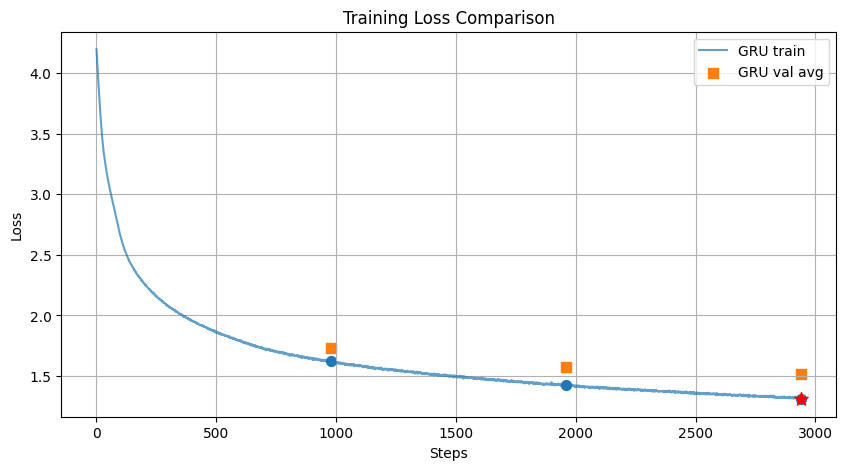

In [25]:
plot_loss_comparisons()

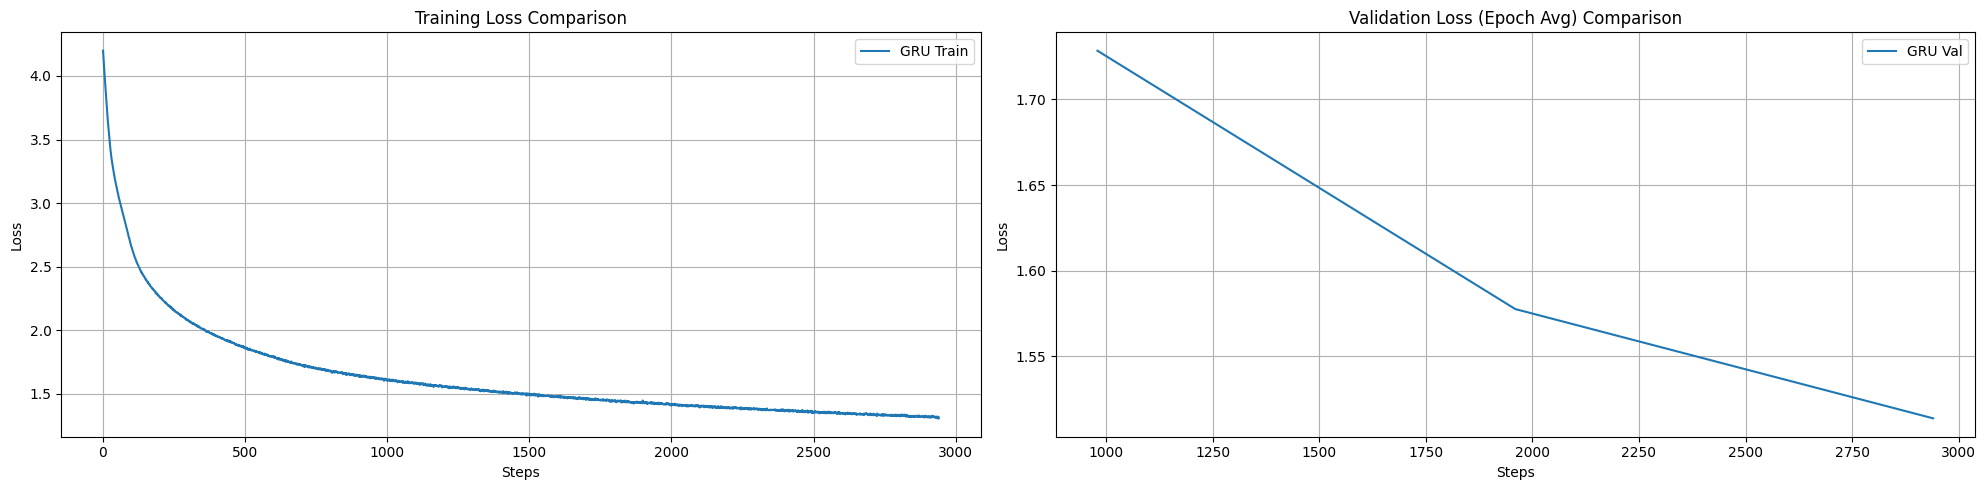

In [26]:
plot_separate_train_val(loss_comparison_dict)

In [27]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [28]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    print("-"*50)
    print(answer_text)
    print("-"*50)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [29]:
# Hyperparameters for Transformer
NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 480
DROPOUT = 0.1

## Model 2: Modern Transformer

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    # FFN_DIM = HIDDEN_DIM
    FFN_DIM = 320
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [31]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=128, out_features=128, bias=False)
        (wk): Linear(in_features=128, out_features=128, bias=False)
        (wv): Linear(in_features=128, out_features=128, bias=False)
        (wo): Linear(in_features=128, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=320, bias=False)
        (w2): Linear(in_features=320, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=320, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [32]:
from torchinfo import summary

# Describe the model
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [1024, 512, 65]           --
├─Embedding: 1-1                         [1024, 512, 128]          8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1024, 512, 128]          --
│    │    └─RMSNorm: 3-1                 [1024, 512, 128]          128
│    │    └─SelfAttention: 3-2           [1024, 512, 128]          65,568
│    │    └─Dropout: 3-3                 [1024, 512, 128]          --
│    │    └─RMSNorm: 3-4                 [1024, 512, 128]          128
│    │    └─FeedForward: 3-5             [1024, 512, 128]          122,880
│    │    └─Dropout: 3-6                 [1024, 512, 128]          --
│    └─TransformerBlock: 2-2             [1024, 512, 128]          --
│    │    └─RMSNorm: 3-7                 [1024, 512, 128]          128
│    │    └─SelfAttention: 3-8           [1024, 512, 128]          65,

In [33]:
# train_and_test("LLaMA", llama, start_text)

## Model 3: minGRU

In [34]:

# ========================================
# 4) GRU & minGRU CELLS (FROM USER)
# ========================================

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear_ih = nn.Linear(input_size, 3 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 3 * hidden_size)
        self.hidden_size = hidden_size
    def forward(self, x_t, h_prev):
        i_r, i_z, i_n = self.linear_ih(x_t).chunk(3, dim=1)
        h_r, h_z, h_n = self.linear_hh(h_prev).chunk(3, dim=1)
        r = torch.sigmoid(i_r + h_r)
        z = torch.sigmoid(i_z + h_z)
        n = torch.tanh(i_n + r * h_n)
        h = (1 - z) * n + z * h_prev
        return h

def parallel_scan_log(log_coeffs, log_values):
    a_star = F.pad(torch.cumsum(log_coeffs, dim=1), (0,0,1,0))
    log_h0_b = torch.logcumsumexp(log_values - a_star, dim=1)
    log_h = a_star + log_h0_b
    return torch.exp(log_h[:,1:,:])

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear_z = nn.Linear(input_size, hidden_size)
        self.linear_h = nn.Linear(input_size, hidden_size)
    def forward(self, x):
        B, L, _ = x.size()
        Z = torch.sigmoid(self.linear_z(x))
        h0 = torch.zeros(B,1,self.linear_h.out_features, device=x.device)
        log_h0 = torch.log(torch.relu(h0) + 1e-6)
        log_A = torch.log1p(-Z)
        log_B = torch.log(Z) + torch.log(torch.relu(self.linear_h(x)) + 1e-6)
        log_vals = torch.cat([log_h0, log_B], dim=1)
        return parallel_scan_log(log_A, log_vals)

# ========================================
# 5) STACKED GRU & MINGRU NETWORKS
# ========================================

class StackedGRU(nn.Module):
    def __init__(self, embed_dim, vocab_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([
            GRUCell(embed_dim, embed_dim) for _ in range(num_layers)
        ])
        self.head = nn.Linear(embed_dim, vocab_size)
    def forward(self, x):
        h_seq = self.embed(x)           # [B,L,E]
        for cell in self.layers:
            B, L, D = h_seq.size()
            h = torch.zeros(B, D, device=h_seq.device)
            outs = []
            for t in range(L):
                h = cell(h_seq[:,t], h)
                outs.append(h.unsqueeze(1))
            h_seq = torch.cat(outs, dim=1)  # sequence out of this layer
        return self.head(h_seq)         # [B,L,V]

class StackedMinGRU(nn.Module):
    def __init__(self, embed_dim, vocab_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.layers = nn.ModuleList([
            ParallelLogMinGRU(embed_dim, embed_dim) for _ in range(num_layers)
        ])
        self.head = nn.Linear(embed_dim, vocab_size)
    def forward(self, x):
        h_seq = self.embed(x)           # [B,L,E]
        for layer in self.layers:
            h_seq = layer(h_seq)        # [B,L,E]
        return self.head(h_seq)         # [B,L,V]

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 기존 GRUDecoder
class GRUDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor = None):
        """
        x: LongTensor of shape (batch, seq_len)
        hidden: optional initial hidden state (num_layers, batch, hidden_dim)
        returns: logits (batch, seq_len, vocab_size), new_hidden
        """
        embed = self.embedding(x)                           # [B, L, E]
        output, new_hidden = self.gru(embed, hidden)        # [B, L, H]
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))                   # [B, L, H]
        logits = self.fc2(output)                           # [B, L, V]
        return logits, new_hidden


# ParallelLogMinGRU cell from your 코드
def parallel_scan_log(log_coeffs, log_values):
    a_star = F.pad(torch.cumsum(log_coeffs, dim=1), (0,0,1,0))
    log_h0_b = torch.logcumsumexp(log_values - a_star, dim=1)
    log_h = a_star + log_h0_b
    return torch.exp(log_h[:,1:,:])

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.linear_z = nn.Linear(input_size, hidden_size)
        self.linear_h = nn.Linear(input_size, hidden_size)

    def forward(self, x: torch.Tensor):
        # x: [B, L, D_in]
        B, L, _ = x.size()
        Z = torch.sigmoid(self.linear_z(x))  # [B, L, H]
        h0 = torch.zeros(B, 1, self.linear_h.out_features, device=x.device)
        log_h0 = torch.log(torch.relu(h0) + 1e-6)
        log_A = torch.log1p(-Z)                              # [B, L, H]
        log_B = torch.log(Z) + torch.log(torch.relu(self.linear_h(x)) + 1e-6)
        log_vals = torch.cat([log_h0, log_B], dim=1)         # [B, L+1, H]
        return parallel_scan_log(log_A, log_vals)            # [B, L, H]


# MinGRUDecoder: GRUDecoder와 동일한 API
class MinGRUDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layers = nn.ModuleList()
        # 첫 레이어: E → H
        self.layers.append(ParallelLogMinGRU(embedding_dim, hidden_dim))
        # 추가 레이어: H → H
        for _ in range(num_layers - 1):
            self.layers.append(ParallelLogMinGRU(hidden_dim, hidden_dim))

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x: torch.Tensor):
        """
        x: LongTensor of shape (batch, seq_len)
        returns: logits (batch, seq_len, vocab_size)
        """
        h = self.embedding(x)            # [B, L, E]
        for layer in self.layers:
            h = layer(h)                 # [B, L, H] → next layer
        h = self.dropout(h)
        h = self.layer_norm(h)
        h = F.gelu(self.fc1(h))          # [B, L, H]
        logits = self.fc2(h)             # [B, L, V]
        return logits, _


In [43]:
### Model Initialization
custom_gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE)

In [44]:
from torchinfo import summary

summary(custom_gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [1024, 512, 65]           --
├─Embedding: 1-1                         [1024, 512, 128]          8,320
├─GRU: 1-2                               [1024, 512, 256]          691,200
├─Dropout: 1-3                           [1024, 512, 256]          --
├─LayerNorm: 1-4                         [1024, 512, 256]          512
├─Linear: 1-5                            [1024, 512, 256]          65,792
├─Linear: 1-6                            [1024, 512, 65]           16,705
Total params: 782,529
Trainable params: 782,529
Non-trainable params: 0
Total mult-adds (G): 362.48
Input size (MB): 4.19
Forward/backward pass size (MB): 4030.73
Params size (MB): 3.13
Estimated Total Size (MB): 4038.05

Epoch 1/3, Train Loss: 1.5954, Val Loss: 1.7265, Epoch Time: 97.94s Average Vram Usage: 903.74MB


Epoch 2/3, Train Loss: 1.3891, Val Loss: 1.6466, Epoch Time: 100.94s Average Vram Usage: 903.74MB


Epoch 3/3, Train Loss: 1.2865, Val Loss: 1.6456, Epoch Time: 101.13s Average Vram Usage: 903.74MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
You wrong me, Signior Gremio: give me leave.
I am a gentleman of Verona, sir,
That, hearing of her beauty and her wit,
Her affability and bashful modesty,
Her wondrous qualities and mild behavi]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
Y

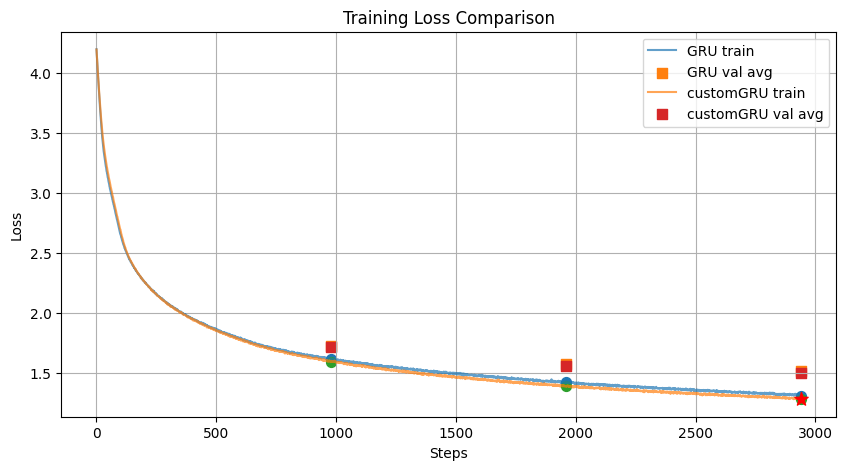

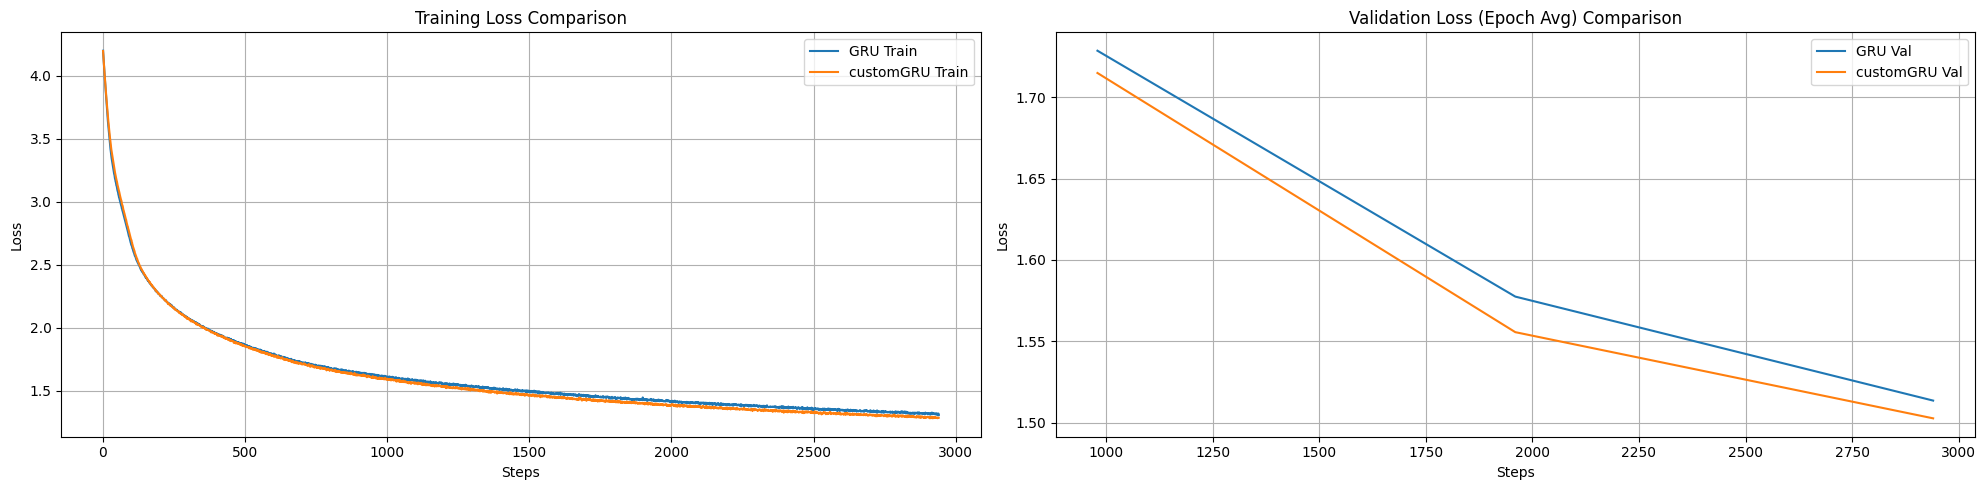

In [45]:
train_and_test("customGRU", custom_gru, start_text)

In [50]:
### Model Initialization
mingru = MinGRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE)

In [51]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
MinGRUDecoder                            [1024, 512, 65]           --
├─Embedding: 1-1                         [1024, 512, 128]          8,320
├─ModuleList: 1-2                        --                        --
│    └─ParallelLogMinGRU: 2-1            [1024, 512, 256]          --
│    │    └─Linear: 3-1                  [1024, 512, 256]          33,024
│    │    └─Linear: 3-2                  [1024, 512, 256]          33,024
│    └─ParallelLogMinGRU: 2-2            [1024, 512, 256]          --
│    │    └─Linear: 3-3                  [1024, 512, 256]          65,792
│    │    └─Linear: 3-4                  [1024, 512, 256]          65,792
├─Dropout: 1-3                           [1024, 512, 256]          --
├─LayerNorm: 1-4                         [1024, 512, 256]          512
├─Linear: 1-5                            [1024, 512, 256]          65,792
├─Linear: 1-6                            [1024, 512, 65]     

Epoch 1/3, Train Loss: 1.7083, Val Loss: 1.8292, Epoch Time: 148.53s Average Vram Usage: 910.28MB


Epoch 2/3, Train Loss: nan, Val Loss: 1.7531, Epoch Time: 148.53s Average Vram Usage: 910.28MB


Epoch 3/3, Train Loss: nan, Val Loss: 1.7531, Epoch Time: 147.13s Average Vram Usage: 910.28MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
You wrong me, Signior Gremio: give me leave.
I am a gentleman of Verona, sir,
That, hearing of her beauty and her wit,
Her affability and bashful modesty,
Her wondrous qualities and mild behavi]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
You 

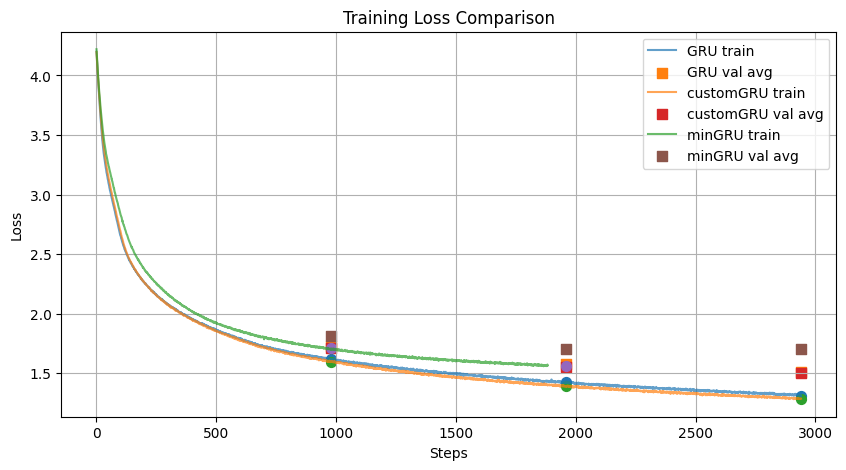

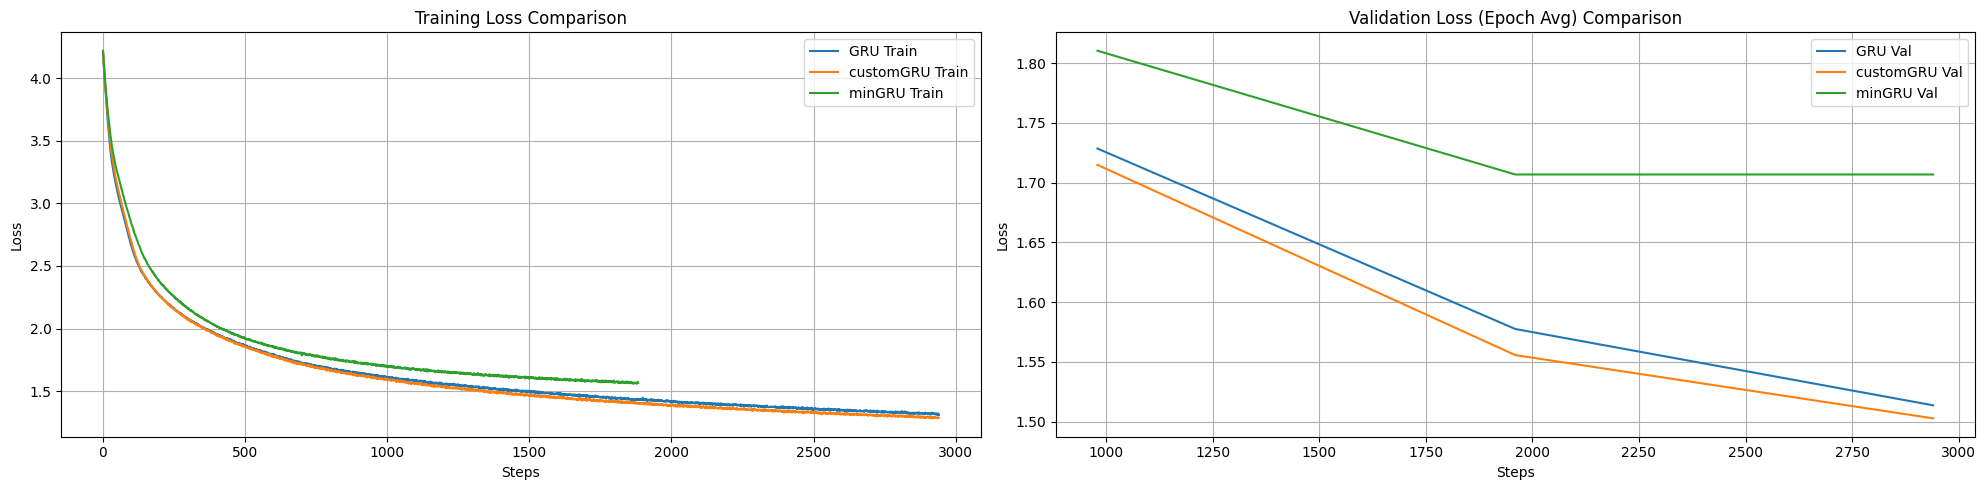

In [52]:
train_and_test("minGRU", mingru, start_text)